In [ ]:

import numpy as np
from sklearn import metrics


##### SOC_Data holds the value from a single call to SOC.soc()

In [ ]:
class SOC_Data:
    def __init__(self, dd, part, cc_norm, idx, c_disp, clst, m, SL, n, d1) -> None:
        self.dd = dd
        self.part = part
        self.cc_norm = cc_norm
        self.idx = idx
        self.c_disp = c_disp
        self.clst = clst
        self.m = m
        self.SL = SL
        self.n = n
        self.d1 = d1

##### SOC class takes two argument in constructor -> nk {number of cluster} and max_iter {maximum iteration if not converged before, set to 10 by default as per Paper}

In [ ]:
class SOC:
    def __init__(self, nk=4, max_iter=10) -> None:
        self._nk = nk
        self._max_iter = max_iter

    def lagrangepoly(self, X, Y, XX=None, nargout=2):
        # Make sure that X and Y are row vectors
        if X.ndim > 1:
            X = X.flatten()
        if Y.ndim > 1:
            Y = Y.flatten()
        if X.ndim > 1 or Y.ndim > 1 or X.size != Y.size:
            raise ValueError('both inputs must be equal-length vectors')

        N = len(X)

        pvals = np.zeros((N, N),dtype=np.double)

        for i in range(N):
            pp = np.poly(X[np.arange(N) != i])
            pvals[i,:] = pp / np.polyval(pp, X[i])

        P = np.dot(Y, pvals)

        if XX is not None:
            YY = np.polyval(P, XX)
            # assign to output
            P = YY

        if nargout > 1:
            R = np.roots(np.arange(N-1, -1, -1) * P[:N])
            if nargout > 2:
                S = np.polyval(P,R)
                return P,R,S
            else:
                return P,R
        else:
            return P

    def slht(self, s, idx, n, m):
        S_const = np.zeros(self._nk, dtype=np.double)
        for r in range(n):
            S_const[int(idx[r])] += s[r]
        S = np.zeros(self._nk, dtype=np.double)
        for j in range(self._nk):
            S[j] = (1/m[j]) * S_const[j]
        GS = (1/self._nk) * np.sum(S)
        return S, GS*1.3

    def soc(self, x, factor):
        n, k = x.shape
        x_min = x.min(axis=0)
        x_max = x.max(axis=0)
        z = x_max - x_min
        u = np.zeros((n, k))
        for j in range(n):
            y = x[j] - x_min
            if np.all(z != 0):
                w = y / z
            else:
                w = np.zeros(k)
            u[j] = w

        U = u.copy()
        u = u.astype(float)
        m = np.zeros(self._nk, dtype=np.double)
        t = np.zeros(self._nk + 1, dtype=np.double)
        t[0] = n

        sl = np.zeros((n, self._nk+1), dtype=np.double)
        for i in range(n):
            sl[i][0] = i

        d1 = np.zeros(self._nk, dtype=np.double)
        P = np.zeros((n, self._nk), dtype=np.double)
        ymax = np.zeros(self._nk, dtype=np.double)
        zmax = np.zeros(self._nk, dtype=np.double)
        SL = np.zeros((n, self._nk), dtype=np.double)
        clst = np.zeros((n, k, self._nk), dtype=np.double)
        c_disp = np.zeros((n, k, self._nk+1), dtype=np.double)
        ex = np.zeros((n, k), dtype=np.double)
        d = np.zeros(self._nk, dtype=np.double)
        cc_norm = np.zeros((self._nk, k), dtype=np.double)

        for v in range(self._nk):
            if t[v] != 0: # vth cluster is not empty
                d[v] = 0
                for j in range(int(t[v])):
                    if x[int(sl[j, v])].sum() != 0:
                        d[v] += x[int(sl[j, v])].min() / x[int(sl[j, v])].sum()

                d1[v] = (1 / (2 * t[v])) * d[v] * factor[v]

                for r in range(int(t[v])):
                    P[r, v] = 0
                    for j in range(int(t[v])):
                        P[r, v] += np.exp(-((u[r] - u[j]) @ (u[r] - u[j])) / (d1[v] ** 2))


                ymax[v], zmax[v] = P[:, v].max(), int(P[:, v].argmax())
                cc_norm[v] = u[int(zmax[v])]
                cc_norm = cc_norm.astype(float)
                for r in range(int(t[v])):
                    if (u[r] - cc_norm[v]) @ (u[r] - cc_norm[v]) <= d1[v]:
                        SL[int(m[v]), v] = sl[r, v]
                        for i in range(k):
                            clst[int(m[v]), i, v] = x[int(sl[r, v]), i]
                            c_disp[int(sl[r, v]), i, v] = x[int(sl[r, v]), i]
                            ex[int(sl[r, v]), i] = 255
                        m[v] += 1
                    else:
                        sl[int(t[v + 1]), v + 1] = sl[r, v]
                        for i in range(k):
                            u[int(t[v + 1]), i] = u[r, i]
                            ex[int(sl[r, v]), i] = x[int(sl[r, v]), i]
                            c_disp[int(sl[r, v]), i, v] = 255
                        t[v + 1] += 1
                c_disp[:, :, v + 1] = ex


        if t[self._nk] != 0:
            D = np.zeros((self._nk, int(t[self._nk])), dtype=np.double)
            for r in range(int(t[self._nk])):
                for v in range(self._nk):
                    D[v, r] = (u[r] - cc_norm[v]) @ (u[r] - cc_norm[v])
            zmin = D.argmin(axis=0)
            for r in range(int(t[self._nk])):
                v = zmin[r]
                SL[int(m[v]), v] = sl[r, self._nk]
                clst[int(m[v]), :, v] = x[int(sl[r, self._nk])]
                c_disp[int(sl[r, self._nk]), :, v] = x[int(sl[r, self._nk])]
                m[v] += 1

        dd = np.zeros((n, self._nk), dtype=np.double)
        idx = np.zeros(n, dtype=np.double)
        for r in range(n):
            for v in range(self._nk):
                if m[v] != 0:
                    dd[r, v] = (U[r] - cc_norm[v]) @ (U[r] - cc_norm[v])
                    for j in range(int(m[v])):
                        if (x[r] == clst[j, :, v]).all():
                            idx[r] = v

        part = np.zeros((n, self._nk), dtype=np.double)
        for j in range(n):
            label = dd[j].argmin()
            part[j, label] = 1

        result = SOC_Data(
        dd,
        part,
        cc_norm,
        idx,
        c_disp,
        clst,
        m,
        SL,
        n,
        d1
    )
        return result


    def squared_euclidean(self, u, v):
        return np.sum((u - v) ** 2)

    def factorcal(self, x,iter):
        flag = 0
        factor = np.ones((self._max_iter+1,self._nk))
        GS = np.zeros((self._max_iter))
        while iter < self._max_iter:
            print(f"current iteration = {iter}")
            result = self.soc(x,factor[iter,:])
            s = metrics.silhouette_samples(x.astype(float), result.idx, metric=self.squared_euclidean)
            S, GS[iter] = self.slht(s, result.idx, result.n, result.m)
            if min(result.m) == 0:
                flag = 1
                break
            for g in range(self._nk-1):
                for gg in range(g+1,self._nk):
                    if result.d1[g] == result.d1[gg]:
                        flag = 1
            if flag == 1:
                break

            polym, _ = self.lagrangepoly(result.d1,S)
            polym[self._nk-1] -= 1
            r = np.roots(polym)
            sumn = np.zeros(r.shape, dtype=np.clongdouble)
            for i in range(self._nk-1):
                for j in range(self._nk):
                    sumn[i] += polym[self._nk-j-1] * r[i]**(j)
            label = np.argmin(np.abs(sumn))
            dmax = abs(r[label])
            factor[iter+1,:] = dmax/result.d1
            iter += 1
        label=np.argmax(GS)
        fac=factor[label,:]
        return fac


    def fit(self, X):
        fac = self.factorcal(X, 0)
        result = self.soc(X, fac)
        s = metrics.silhouette_samples(X.astype(float), result.idx)
        _, GSS = self.slht(s, result.idx, result.n, result.m)

        return GSS, s, result


##### Cluster results with nk = 4 and iter = 10 for image p2.jpg in the paper converted as csv for clustering

In [ ]:

x = np.genfromtxt('data.csv', delimiter=',')
f, h = x.shape
nk = 4
print(x.shape)

soc_solver = SOC(nk = 4, max_iter = 10)
GSS, _, _ = soc_solver.fit(x)

print(f"GSS = {GSS}")

(4150, 3)
current iteration = 0
current iteration = 1
current iteration = 2
current iteration = 3
current iteration = 4
current iteration = 5
current iteration = 6
current iteration = 7
current iteration = 8
current iteration = 9
GSS = 0.6900696716856974


##### Clustering performed on the Iris dataset

In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data

for nk in range(3, 7):
  soc_solver = SOC(nk)
  GSS, _, _ = soc_solver.fit(X)
  print(f"GSS for iris dataset and nk = {nk} = {GSS}")

current iteration = 0
current iteration = 1
current iteration = 2
current iteration = 3
current iteration = 4
current iteration = 5
current iteration = 6
current iteration = 7
current iteration = 8
current iteration = 9
GSS for iris dataset and nk = 3 = 0.7008619580801612
current iteration = 0
current iteration = 1
GSS for iris dataset and nk = 4 = 0.5209531961186851
current iteration = 0
current iteration = 1
current iteration = 2
current iteration = 3
current iteration = 4
current iteration = 5
current iteration = 6
current iteration = 7
current iteration = 8
current iteration = 9
GSS for iris dataset and nk = 5 = 0.4273074293360565
current iteration = 0
current iteration = 1
current iteration = 2
current iteration = 3
current iteration = 4
current iteration = 5
current iteration = 6
current iteration = 7
current iteration = 8
current iteration = 9
GSS for iris dataset and nk = 6 = 0.43309544258144905


In [ ]:
from PIL import Image
import numpy as np
img = Image.open(r"/content/test.jpeg")
img = np.array(img)
print(img.shape)

x = np.reshape(img, (img.shape[0]*img.shape[1], 3))
for nk in range(2, 6):
    soc_solver = SOC(nk, max_iter=5)
    GSS, _, _ = soc_solver.fit(x)
    print(f"GSS value for {nk} cluster is {GSS}")

(30, 30, 3)
current iteration = 0
current iteration = 1
current iteration = 2
current iteration = 3
current iteration = 4
GSS value for 2 cluster is 0.7376034952422351
current iteration = 0
current iteration = 1
current iteration = 2
current iteration = 3
current iteration = 4
GSS value for 3 cluster is 0.700698090859737
current iteration = 0
current iteration = 1
current iteration = 2
current iteration = 3
current iteration = 4
GSS value for 4 cluster is 0.5574579781616562
current iteration = 0
current iteration = 1
current iteration = 2
current iteration = 3
current iteration = 4
GSS value for 5 cluster is 0.5212111517091295


Image used in above SOC algorithm

In [ ]:
Img = Image.open(r"/content/test.jpeg")
Img.show()

Image converted as data.csv and used to calculate GSI values

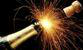

In [ ]:
Img = Image.open(r"/content/p2.jpg")
Img.show()